In [63]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 

## Data Loading

In [64]:
import dostools.datasets.data as data
import dostools.utils.utils as utils
importlib.reload(data)

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
#     y_pw = ldos - mean_dos_per_atom
#     y_lcdf = torch.cumsum(y_pw, dim = 1)
#     _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
#     y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
#     Silicon = data.load_features()
#     kMM = data.load_kMM()
#     structure_eigvals_t, structure_coefficients_t, reconstructed_ldos_t = data.load_structure_gaussians()


ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])


In [65]:
# sigma = 0.3
# dx = 0.05
# eigen_energies, emin, emax = data.load_eigenenergies(unpack = True, n_structures = 1039)
# full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
# eigenenergy_length = [len(i) for i in full_eigen_energies]
# eigenenergy_length_t = torch.tensor(eigenenergy_length)
# n_atoms_t = torch.tensor(n_atoms)
# normalization_eiglength = [len(i) for i in eigen_energies]
# normalization_eiglength_t = torch.tensor(normalization_eiglength)
# normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms_t/normalization_eiglength_t
# normalization_quartic = 1/n_atoms/normalization_eiglength_t

In [66]:
#Try for full ldos and shifted ldos for splines
emin = -24.553719539983
max_efermi = -4.3758
# emax = 11.346414696331
Total_splines = torch.load("./Splines_dataset3.pt").float()
# lower_bound = torch.round(torch.tensor(emin-1.5).float(), decimals = 3)
# upper_bound = torch.round(torch.tensor(max_efermi+3).float(), decimals = 3)
# n_points = ((upper_bound - lower_bound)/0.001).long()
# xaxis = torch.linspace(lower_bound,upper_bound,n_points).float()
lower_bound = -24.553719539983-3
upper_bound = -4.3758+3
xaxis = torch.arange(lower_bound,upper_bound,0.001)
import dostools.datasets.data as data
xdos = torch.tensor(data.load_xdos())

In [67]:
def manual_call2(spline_coefs, spline_positions, x):
    """
    spline_coefs: shape of (n x 4 x spline_positions)
    
    return value: shape of (n x x)
    """
    interval = torch.round(spline_positions[1] - spline_positions[0], decimals = 4)
    indexes = torch.floor((x - spline_positions[0])/interval).long()
    expanded_index = indexes.unsqueeze(dim=1).expand(-1,4,-1)
    x_1 = x - spline_positions[indexes]
    x_2 = x_1 * x_1
    x_3 = x_2 * x_1
    x_0 = torch.ones_like(x_1)
    x_powers = torch.stack([x_3, x_2, x_1, x_0]).permute(1,0,2)
    value = torch.sum(torch.mul(x_powers, torch.gather(spline_coefs, 2, expanded_index)), axis = 1) 
    
    
    return value

In [68]:
import rascaline
from skcosmo.feature_selection import FPS
import scipy

HYPER_PARAMETERS = {
    "cutoff": 4.0,#6.0,#4.0,
    "max_radial": 8,#12,#8,
    "max_angular": 6,#9,#6,
    "atomic_gaussian_width": 0.45,
    "center_atom_weight": 1.0,
    "radial_basis":{
        "Gto":{}
    },
    "cutoff_function":{
        "Step":{}, #maybe 
    },
    "radial_scaling":{
        "Willatt2018":{
        'exponent': 5,
        'rate' : 1,
        'scale' : 3.,
        },
    },
}

calculator = rascaline.SoapPowerSpectrum(**HYPER_PARAMETERS)
descriptors = calculator.compute(structures)
descriptors.keys_to_samples("species_center")
descriptors.keys_to_properties(["species_neighbor_1", "species_neighbor_2"])



n_refs = 200
n_atoms = descriptors.block(0).values.shape[0]
n_structures = np.unique(descriptors.block(0).samples["structure"])
feature = torch.zeros(len(n_structures), n_refs)
atom_descriptors = torch.tensor(descriptors.block(0).values)
atom_descriptors = torch.nn.functional.normalize(atom_descriptors, dim = 1)
selector = FPS(n_to_select = n_refs,
           progress_bar = True,
           score_threshold = 1e-12,
           full = False,
           initialize = 0
          )
selector.fit(atom_descriptors.T)
references = selector.transform(atom_descriptors.T).T
atomkernel_descriptors = torch.pow(atom_descriptors @ references.T, 2)
for structure_i in n_structures:
    a_i = descriptors.block(0).samples["structure"] == structure_i
    feature[structure_i, :] = torch.sum(atomkernel_descriptors[a_i, :], axis = 0)/np.sum(a_i)

kMM = references @ references.T
rtkMM = scipy.linalg.sqrtm(kMM)

  0%|          | 0/199 [00:00<?, ?it/s]

In [69]:
pred_xdos = torch.arange(lower_bound+1.5, upper_bound - 1, 0.05)

## Unbiased Index

In [131]:
from dostools.loss import loss
#normal dataset


index = train_index
t_index = test_index



Features = torch.hstack([feature[index], torch.ones(len(index)).view(-1,1)])#.type(dtype = torch.complex128)
t_Features = torch.hstack([feature[t_index], torch.ones(len(t_index)).view(-1,1)])#.type(dtype = torch.complex128)
# Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
# t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))
# alignment = torch.nn.parameter.Parameter((torch.rand(len(index))-0.5) *2 ) 



xdos_i = xdos.clone()
# cutoff = torch.max(efermi) + 3
# cutoff_index = torch.searchsorted(xdos, cutoff)

train_ldos = manual_call2(Total_splines[index], xaxis, pred_xdos + alignment.view(-1,1))
test_ldos = manual_call2(Total_splines[t_index], xaxis, pred_xdos + torch.zeros(len(t_index)).view(-1,1))

best_mse = torch.tensor(100)
best_state = alignment.clone()

n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights



train_loss = loss.t_get_rmse(reference_pred, train_ldos, pred_xdos, perc = True)#torch.mean(abs(reference_pred- train_ldos)**2) 
test_loss = loss.t_get_rmse(reference_t_pred, test_ldos, pred_xdos, perc = True)#torch.mean(abs(reference_t_pred- test_ldos)**2) 

print ("Reference training loss: {:.6}".format(train_loss))
print ("Reference test loss : {:.6}".format(test_loss))


Reference training loss: 10.5108
Reference test loss : 11.9648


In [221]:
#Monte Carlo Step

B = 1000000 #Need to change
step_size = 1e-4 #Need to change
# alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))
# loss_trajectory = []
# prev_loss = loss.t_get_rmse(reference_pred, train_ldos, pred_xdos, perc = False)
# best_mse = prev_loss.clone()
batch_size = 831
n_epochs = 3000
patience = 20

prev_loss = torch.tensor(1)

current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)

print ("Initial RMSE is {}".format(prev_loss))
trigger = 0
accepted = 0

with torch.no_grad():
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch}")
        pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), current_loss = prev_loss.item())
        
        #MC
        new_alignment = alignment + (torch.rand(len(index)) - 0.5)* 2 * step_size
        shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + new_alignment.view(-1,1))
        shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   
        train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
        shifted_train_preds = Features @ train_weights
        loss_i = loss.t_get_rmse(shifted_train_preds, shifted_target, pred_xdos)
        pred_loss = loss_i

        criteria = torch.exp(B*(prev_loss - loss_i))
        acceptance = torch.rand(1)
        
        if acceptance < criteria:
            alignment = new_alignment
            prev_loss = loss_i
            loss_trajectory.append(loss_i.item())
            accepted += 1
        else:
            loss_trajectory.append(prev_loss.item())
            
        if loss_i < best_mse:
            best_mse = loss_i
        
        

Initial RMSE is 0.04557377558334627


Epoch: 2999: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:03<00:00, 12.30it/s, current_loss=0.0453, lowest_mse=0.0453, pred_loss=0.0453]


In [216]:
loss.t_get_rmse(reference_pred, train_ldos, pred_xdos, perc = False) - best_mse 

tensor(0., grad_fn=<SubBackward0>)

In [217]:
accepted/n_epochs

0.988

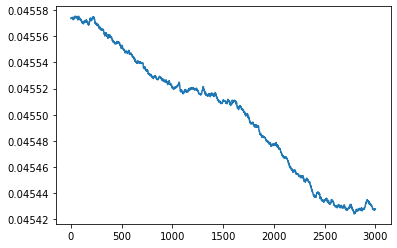

In [220]:
plt.plot(np.arange(len(loss_trajectory)), np.array(loss_trajectory))

In [289]:
#Monte Carlo Step batchwise-R

B = 100000 #Need to change
step_size = 1e-2 #Need to change

batch_size = 32
n_epochs = 10000
patience = 20
accepted = 0
total = 0
AR = 0
# alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))
# loss_trajectory = []
# prev_loss = loss.t_get_rmse(reference_pred, train_ldos, pred_xdos, perc = False)
# best_mse = prev_loss.clone()



Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)

print ("Initial RMSE is {}".format(prev_loss))
trigger = 0

loss_p = 0

with torch.no_grad():
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch}")
        pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), current_loss = prev_loss.item(), AR = AR, p_loss = loss_p)
        #MC
        for i_batch in Batcher:
            new_alignment = alignment.clone()
            new_alignment[i_batch] += (torch.rand(len(i_batch)) - 0.5)* 2 * step_size
            new_alignment = torch.clamp(new_alignment, -1.5, 1)
#             reg_features_i = torch.vstack([Features[i_batch], reg])
            shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + new_alignment.view(-1,1))
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   
            train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
            shifted_train_preds = Features @ train_weights
            loss_i = loss.t_get_rmse(shifted_train_preds, shifted_target, pred_xdos)
            loss_p = loss.t_get_rmse(shifted_train_preds, shifted_target, pred_xdos, perc = True).item()
            pred_loss = loss_i

            criteria = torch.exp(B*(prev_loss - loss_i))
            acceptance = torch.rand(1)

            if acceptance < criteria:
                alignment = new_alignment
                prev_loss = loss_i
                loss_trajectory.append(loss_i.item())
                accepted += 1
            else:
                loss_trajectory.append(prev_loss.detach().item())

            if loss_i < best_mse:
                best_mse = loss_i
            total +=1
        AR = accepted/total


Initial RMSE is 0.03926728713002782


Epoch: 9999: 100%|████████████████████████████████████████████████████████████████| 10000/10000 [6:37:01<00:00,  2.38s/it, AR=0.475, current_loss=0.0391, lowest_mse=0.0385, p_loss=9.15, pred_loss=0.0391]


In [282]:
torch.min(new_alignment)

tensor(-0.8474)

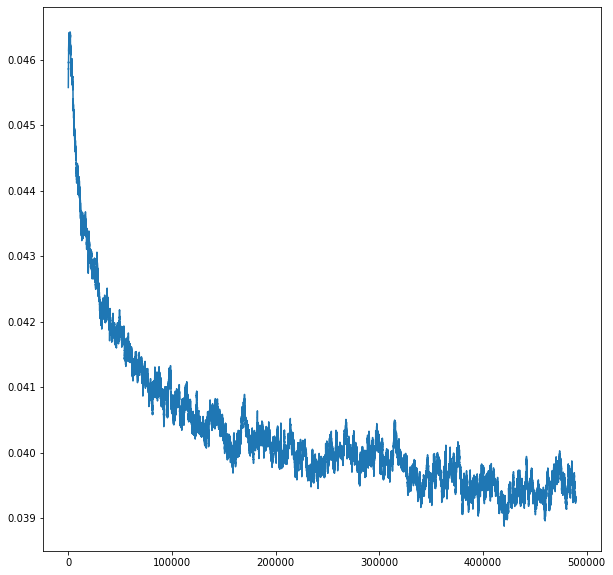

In [288]:
plt.plot(loss_trajectory)

In [ ]:
#Monte Carlo Step batchwise-R

B = 1000000 #Need to change
step_size = 1e-2 #Need to change

batch_size = 32
n_epochs = 10000
patience = 20
accepted = 0
total = 0
AR = 0
# alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))
# loss_trajectory = []
# prev_loss = loss.t_get_rmse(reference_pred, train_ldos, pred_xdos, perc = False)
# best_mse = prev_loss.clone()



Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

prev_loss = torch.tensor(1)

current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)

print ("Initial RMSE is {}".format(prev_loss))
trigger = 0

loss_p = 0

with torch.no_grad():
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch}")
        pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), current_loss = prev_loss.item(), AR = AR, p_loss = loss_p)
        #MC
        for i_batch in Batcher:
            new_alignment = alignment.clone()
            new_alignment[i_batch] += (torch.rand(len(i_batch)) - 0.5)* 2 * step_size
            new_alignment = torch.clamp(new_alignment, -1.5, 1)
#             reg_features_i = torch.vstack([Features[i_batch], reg])
            shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + new_alignment.view(-1,1))
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   
            train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
            shifted_train_preds = Features @ train_weights
            loss_i = loss.t_get_rmse(shifted_train_preds, shifted_target, pred_xdos)
            loss_p = loss.t_get_rmse(shifted_train_preds, shifted_target, pred_xdos, perc = True).item()
            pred_loss = loss_i

            criteria = torch.exp(B*(prev_loss - loss_i))
            acceptance = torch.rand(1)

            if acceptance < criteria:
                alignment = new_alignment
                prev_loss = loss_i
                loss_trajectory.append(loss_i.item())
                accepted += 1
            else:
                loss_trajectory.append(prev_loss.detach().item())

            if loss_i < best_mse:
                best_mse = loss_i
            total +=1
        AR = accepted/total


In [ ]:
plt.plot(loss_trajectory)

In [239]:
accepted/ (26 * 500)

0.1453846153846154

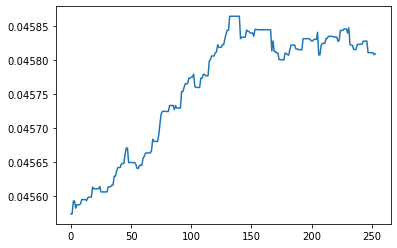

In [250]:
plt.plot(np.arange(len(loss_trajectory)), np.array(loss_trajectory))

In [ ]:
#Monte Carloception

B = 1000000 #Need to change
step_size = 1e-2 #Need to change
alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))
batch_size = 32
n_epochs = 500
patience = 20

Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

prev_loss = torch.tensor(1)

current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = loss.t_get_rmse(reference_pred, train_ldos, pred_xdos, perc = False)
best_mse = prev_loss.clone()
print ("Initial RMSE is {}".format(prev_loss))
trigger = 0
accepted = 0
loss_trajectory = []
with torch.no_grad():
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch}")
        pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), current_loss = prev_loss.item())
        #MC
        for i_batch in Batcher:
            new_alignment = alignment.clone()
            new_alignment[i_batch] += (torch.rand(len(i_batch)) - 0.5)* 2 * step_size
#             reg_features_i = torch.vstack([Features[i_batch], reg])
            shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + new_alignment.view(-1,1))
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   
            train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
            shifted_train_preds = Features @ train_weights
            loss_i = loss.t_get_rmse(shifted_train_preds, shifted_target, pred_xdos)
            pred_loss = loss_i

            criteria = torch.exp(B*(prev_loss - loss_i))
            acceptance = torch.rand(1)

            if acceptance < criteria:
                alignment = new_alignment
                prev_loss = loss_i
                loss_trajectory.append(loss_i.item())
                accepted += 1
            else:
                loss_trajectory.append(prev_loss.item())

            if loss_i < best_mse:
                best_mse = loss_i

In [ ]:
#Gradient Descent

n_epochs = 1000000
batch_size = 32
patience = 20

opt = torch.optim.Adam([alignment], lr = 1e-3, weight_decay = 0)
# opt_LBFGS = torch.optim.LBFGS([alignment], lr = 1e-3, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 20, threshold = 1e-5, min_lr = 1e-8)


pbar = tqdm(range(n_epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), trigger = trigger)
    for i_batch in Batcher:
        def closure():
            opt.zero_grad()
            reg_features_i = torch.vstack([Features[i_batch], reg])
            shifted_target = manual_call2(Total_splines[index[i_batch]], xaxis, pred_xdos + alignment[i_batch].view(-1,1))
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
            train_weights = torch.linalg.lstsq(reg_features_i, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
            shifted_train_preds = Features[i_batch] @ train_weights
            loss_i = loss.t_get_mse(shifted_train_preds, shifted_target)#torch.mean(abs(shifted_train_preds - shifted_target)**2) 
            loss_i.backward(inputs = alignment)
            return loss_i
        opt.step(closure)
        train_ldos = train_ldos.detach()
        
    with torch.no_grad():
        shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + alignment.view(-1,1))
        shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
        train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
        pred_i = Features @ train_weights
        
        
        i_loss = loss.t_get_rmse(pred_i, shifted_target)#torch.mean(abs(pred_i - shifted_target)**2) 
        pred_loss = loss.t_get_rmse(pred_i, shifted_target, pred_xdos, perc = True)
#         pred_loss = i_loss
        if i_loss < prev_loss * (1 + 1e-3): 
            trigger = 0
        else:
            trigger +=1 
            if trigger >= patience:
                alignment = torch.nn.parameter.Parameter(best_state)
                opt = torch.optim.Adam([alignment], lr = opt.param_groups[0]['lr'], weight_decay = 0)
                counter = 0

        if i_loss < best_mse:
            best_mse = i_loss
            best_state = alignment.clone()

        prev_loss = i_loss

        scheduler.step(i_loss)
        if Batcher.batch_size > 1024:
            break
            
        if opt.param_groups[0]['lr'] < 1e-3:
            Batcher.batch_size *= 2 
            opt.param_groups[0]['lr'] = 1e-3
            print ("The batch_size is now:", Batcher.batch_size)

            
            


shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + best_state.view(-1,1))
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,shifted_target.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = loss.t_get_rmse(shifted_preds, shifted_target, pred_xdos, perc = True)#torch.mean(abs(shifted_preds - shifted_target)**2)#
# shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

print ("Final training loss: {:.6}".format(shifted_train_loss))
